# Tutorial: Decoding Network Patterns with JointCRep: A User-Friendly Guide

Welcome to our tutorial on `JointCRep` - an advanced tool from the Probabilistic Generative Models for Network Analysis (`pgm`) package. Traditional community detection models struggle to capture complex network structures. This is where `JointCRep` comes in. It's not just about finding communities, it's about understanding and capturing the complex relationships within networks [1].

 The `JointCRep` ("Joint Community and Reciprocity") model is a tool that helps us to better understand complex networks. In real-world scenarios, networks often exhibit complex patterns of interactions. Consider, for example, a social network where the connections between people aren't random, but influenced by various factors such as shared interests, geographical proximity, etc.  The `JointCRep` model captures these complex interaction patterns by considering the connections between pairs of nodes in the network together, rather than independently. This is different from standard models, which assume that the connections between pairs of nodes are independent once we know certain hidden factors.

## Preliminaries

### What's Inside?
`JointCRep` is more than a community detector. It's an algorithm that dives deep into network nuances, especially reciprocity—the give-and-take nature of connections.

### Highlights
- **Reciprocity in Focus:** `JointCRep` nails reciprocity by precisely modeling how pairs of edges interact, providing a rich view of network dynamics.
  
- **Easy Interpretation:** Forget complicated math. `JointCRep` offers simple, ready-to-use insights about your network's structure.

### What to Expect
- **Real-World Performance:** We'll show you how `JointCRep` shines on real data, effortlessly finding communities, predicting edges, and generating networks that mimic the intricate connectivity patterns observed in diverse and dynamic complex systems.
  
- **User-Friendly Implementation:** Our algorithm is built for efficiency. It scales up without losing speed, making it a practical choice for real-world data.

### Get Ready
This tutorial assumes you know the basics about the `pgm` and are familiar with the [CRep algorithm (tutorial)](./CRep.ipynb). If you're ready to explore networks, join us to see how with `JointCRep`!

## Importing the data

In [2]:
import networkx as nx
import numpy as np
import sklearn
import yaml

Before we enter the fascinating world of JointCRep, let's make sure we have the right data. In this section we'll prepare our network data using the `pgm` package. We analyze the performance of the algorithm in the context of a high school friendship network. The network is represented as an adjacency matrix, where each row and column corresponds to a node in the network. The value of each entry in the matrix indicates whether an edge exists between the corresponding pair of nodes. The network is undirected, meaning that the adjacency matrix is symmetric. The following code snippet imports the network data and prints the number of nodes and edges in the network.

In [3]:
from pathlib import Path
from pgm.input.loader import import_data

# Define the root directory path
root_dir = Path.cwd().parent.parent.parent.resolve()

# Define the input folder path
in_folder = root_dir / 'pgm' / 'data' / 'input'

# Define the adjacency matrix file path
adj = Path('highschool_data.dat')

# Combine the input folder path with the adjacency matrix file path to get the complete path
network = in_folder / adj  # network complete path

# Use the import_data function from the pgm.input.loader module to load the network data
# The function takes several parameters:
# - network: the path to the network data file
# - ego: the column name for the source nodes in the network data
# - alter: the column name for the target nodes in the network data
# - undirected: a flag indicating whether the network is undirected
# - force_dense: a flag indicating whether to force the adjacency matrix to be dense
# - noselfloop: a flag indicating whether to remove self-loops in the network
# - verbose: a flag indicating whether to print verbose output
# - binary: a flag indicating whether the network is binary
# - header: the row number to use as the column names
# The function returns four values:
# - A: a list of adjacency matrices for the network
# - B: the adjacency matrix for the network
# - B_T: the transpose of the adjacency matrix for the network
# - data_T_vals: the observed values for two-edge joint distributions in the network
A, B, B_T, data_T_vals = import_data(network, ego='source', alter='target', undirected=False,
                                     force_dense=False, noselfloop=True, verbose=True, binary=True, header=0)

# Extract the nodes from the first adjacency matrix in the list A
nodes = A[0].nodes()


/home/dtheuerkauf/software-workshop/prob-gen-model-for-nets/pgm/data/input/highschool_data.dat shape: (100, 3)
Creating the network ... Removing self loops

Number of nodes = 31
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 100 - <k> = 6.452
Sparsity [0] = 0.104
Reciprocity (networkX) = 0.52
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.351

Reciprocity (considering the weights of the edges) = 0.52


In the following cell, we focus on configuring the `JointCRep` algorithm. Initially, we set the algorithm variable to `JointCRep` and define the corresponding configuration file path. Using the `importlib.resources` module, we access the configuration file and load its contents utilizing the PyYAML library. The configuration file details are then printed for a quick overview. 

In [5]:
# Set the algorithm to 'JointCRep'
algorithm = 'JointCRep'

# Define the path to the configuration file for the 'JointCRep' algorithm
config_path = 'setting_' + algorithm + '.yaml'

# Import the 'open_binary' function from the 'importlib.resources' module.
# This function is used to open a binary file in read mode.
from importlib.resources import open_binary

# Open the configuration file in binary mode
# The 'open_binary' function takes two arguments:
# - package: the name of the package that the file is part of.
# - resource: the name of the file to open.
with open_binary('pgm.data.model', config_path) as fp:
    # Load the contents of the configuration file using the 'load' function from 
    # the 'yaml' module.
    conf = yaml.load(fp, Loader=yaml.Loader)

# Print the contents of the configuration file
print(yaml.dump(conf))

K: 2
assortative: false
end_file: _JointCRep
eta0: null
files: ../data/input/theta.npz
fix_communities: false
fix_eta: false
fix_w: false
initialization: 0
out_folder: outputs/
out_inference: true
plot_loglik: false
rseed: 10
use_approximation: false


Now, we modify the configuration to customize the behavior of the `JointCRep` algorithm. Specifically, we update the output folder to `./JointCRep_output/`, ensuring a clear distinction in the saved results. Additionally, we disable output related to inference and log-likelihood plotting for a streamlined execution. Further adjustments involve setting verbosity to `False`, the random seed to 0, the number of realizations to 50, and the number of communities (`K`) to 4. 

In [4]:
# Change the output folder to './JointCRep_output/'
# This is where the results of the algorithm will be saved
conf['out_folder'] = './' + algorithm + '_output/'

# Disable output related to inference
# This means that the algorithm will not generate any output related to the 
# inference process, in other words, it won't save the inferred parameters.
conf['out_inference'] = False

# Disable plotting of the log-likelihood
# This means that the algorithm will not generate a plot of the log-likelihood 
# during the fitting process.
conf['plot_loglik'] = False

# Disable verbose output
# This means that the algorithm will not print detailed information about its 
# progress.
conf['verbose'] = False

# Set the random seed to 0
# This is used to ensure reproducibility of the results
conf['rseed'] = 0

# Set the number of realizations to 50
# This is the number of times the algorithm will be run
conf['N_real'] = 50

# Set the number of communities to 4
# This is the number of communities that the algorithm will 
# try to detect.
conf['K'] = 4

We can now save the configuration file to the output folder. This step is optional but recommended for future reference.

In [7]:
# Define the output folder path.
out_folder = Path(conf['out_folder'])

# Check if the output folder exists.
if not out_folder.exists():
    # If the output folder does not exist, create it.
    out_folder.mkdir(parents=True)

# Define the path where the configuration file will be saved.
output_config_path = conf['out_folder'] + '/setting_' + algorithm + '.yaml'

# Open the output configuration file in write mode
with open(output_config_path, 'w') as f:
    # Dump the contents of the configuration dictionary into the file.
    yaml.dump(conf, f)

## Running the model

In this step, we initialize and execute the `JointCRep` model from the `pgm` package. The model is configured with the parameters obtained earlier. The `fit` function is then applied to the input data, including the network, its transpose, observed values for two-edge joint distributions, and relevant node information. The algorithm iteratively refines its parameters to capture community structures and reciprocity patterns in the network.  The resulting parameters for `JointCRep` are stored in the variable `parameters_jointcrep`, facilitating further analysis and evaluation.

In [8]:
from pgm.model.jointcrep import JointCRep

# Set the undirected flag to False.
undirected = False

# Set the flag_conv variable to 'log'
flag_conv = 'log'

# Initialize the JointCRep model
model = JointCRep()

# Fit the JointCRep model to the network data
# The fit function takes several parameters:
# - data: the adjacency matrix for the network.
# - data_T: the transpose of the adjacency matrix for 
# the network.
# - data_T_vals: the observed values for two-edge 
# joint distributions in the network.
# - nodes: a list of nodes in the network.
# - **conf: a dictionary of additional configuration 
# parameters for the model.
parameters_jointcrep = model.fit(data=B,
                                 data_T=B_T,
                                 data_T_vals=data_T_vals,
                                 nodes=nodes,
                                 **conf)

<bound method JointCRep.fit of <pgm.model.jointcrep.JointCRep object at 0x7f2e466c8d90>>
Ignoring extra parameter plot_loglik.
Ignoring extra parameter verbose.
Ignoring extra parameter N_real.
eta is initialized randomly.
u, v and w are initialized randomly.
Updating realization 0 ...
Nreal = 0 - Log-likelihood = -150.45159022589672 - iterations = 100 - time = 0.16 seconds
Nreal = 0 - Log-likelihood = -150.45159022321826 - iterations = 161 - time = 0.29 seconds

eta is initialized randomly.
u, v and w are initialized randomly.
Updating realization 1 ...
Nreal = 1 - Log-likelihood = -143.73119146349333 - iterations = 100 - time = 0.13 seconds
Nreal = 1 - Log-likelihood = -142.58776557575123 - iterations = 200 - time = 0.24 seconds
Nreal = 1 - Log-likelihood = -142.5877655747808 - iterations = 241 - time = 0.29 seconds

eta is initialized randomly.
u, v and w are initialized randomly.
Updating realization 2 ...
Nreal = 2 - Log-likelihood = -144.3077216868701 - iterations = 100 - time = 

### Communities

Now that the results are obtained and the parameters are estimated, we can visually explore the network by leveraging the obtained information. In this segment, we utilize the `NetworkX` library to visualize the graph structure. The following code snippet defines attributes such as node size, colors, and layout to enhance the visual representation. The `node_size` is proportional to the degree of each node, and the `colors` dictionary assigns distinct colors to different communities. The layout of the nodes is determined using the spring layout algorithm. Edges are depicted in dark grey, and nodes are colored in a shade of blue. 

In [9]:
# Create a graph from the first adjacency matrix in the list A
graph = A[0]

# Define the size of each node in the graph, proportional to its degree
node_size = [graph.degree[i] * 10 for i in list(graph.nodes())]

# Define a dictionary of colors for different communities in the graph
colors = {0: 'indianred', 
          1: 'mediumseagreen', 
          2: 'lightskyblue', 
          3: 'sandybrown'}

# Compute the positions of the nodes in the graph using the spring layout algorithm
# The spring layout positions the nodes using a force-directed algorithm, 
# where nodes repel each other and edges act like springs.
# The 'k' parameter adjusts the optimal distance between nodes and 
# 'iterations' defines the number of iterations to perform.
# 'seed' is used for initializing the random number generator.
pos = nx.spring_layout(graph, k=0.05, iterations=100, seed=20)

# Define the color of the edges in the graph
edge_color = 'darkgrey'

# Define the color of the nodes in the graph
node_color = '#3b8bc2ff'

With the estimated parameters in hand, we proceed to analyze the community structure and mixed-memberships within the network. The code segment employs the `normalize_nonzero_membership` function from the `pgm.input.tools` module to normalize the out-going (`u`) and in-coming (`v`) mixed-memberships. The resulting normalized mixed-memberships are stored in the `thetas` dictionary. Furthermore, the code extracts hard-memberships by identifying the community to which each node predominantly belongs. The communities for both out-going and in-coming mixed-memberships are stored in the `communities` dictionary. 

In [10]:
from pgm.input.tools import normalize_nonzero_membership

# Normalize the out-going mixed-memberships from the inferred parameters
u = normalize_nonzero_membership(parameters_jointcrep[0])  

# Normalize the in-coming mixed-memberships from the inferred parameters
v = normalize_nonzero_membership(parameters_jointcrep[1])  

# Store the normalized mixed-memberships in a dictionary for easy access
thetas = {'u': u, 'v': v}

# Extract hard-memberships by identifying the community with 
# the highest membership for each node. This is done by finding 
# the index of the maximum value along axis 1 (i.e., across each row).
# The result is a dictionary where the keys are 'u' and 'v' 
# (representing out-going and in-coming memberships respectively)
# and the values are arrays of community indices.
communities = {'u': np.argmax(u, axis=1), 'v': np.argmax(v, axis=1)}

Now that we have gained insights into the community structure and mixed-memberships, visualizing these results provides a more intuitive understanding. The code snippet utilizes the `plot_hard_membership` function from the `pgm.output.plot` module to generate a visualization of the hard-memberships within the network. The resulting plot employs node sizes proportional to their degrees and color-codes nodes based on their predominant community affiliation. This visual representation offers a clear depiction of how nodes cluster into different communities.

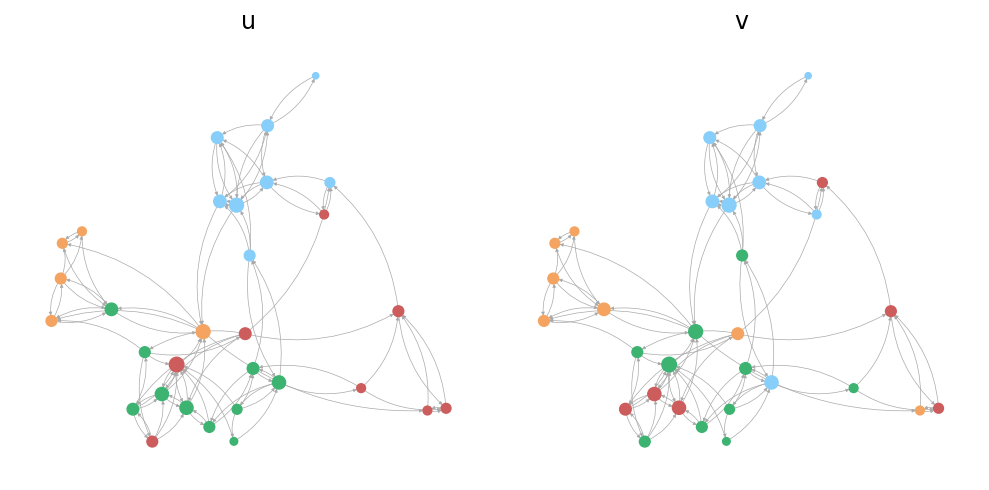

In [11]:
from pgm.output.plot import plot_hard_membership

# Call the plot_hard_membership function from the pgm.output.plot module.
# This function generates a visualization of the hard-memberships within 
# the network. The resulting plot employs node sizes proportional to their 
# degrees and color-codes nodes based on their predominant 
# community affiliation. 
# 'graph' is the NetworkX graph object representing 
# the network 'communities' is a dictionary containing the hard-memberships 
# of nodes 'pos' is a dictionary specifying the positions of nodes in the 
# graph. 
# 'node_size' is a list specifying the size of each node, proportional to 
# its degree.
# 'colors' is a dictionary mapping community indices to colors.
# 'edge_color' is a string specifying the color of the edges in the graph.
_ = plot_hard_membership(graph,
                         communities,
                         pos,
                         node_size,
                         colors,
                         edge_color)

We can also utilize the `plot_soft_membership` function from `pgm.output.plot` to visualize the soft affiliations of nodes with different communities.

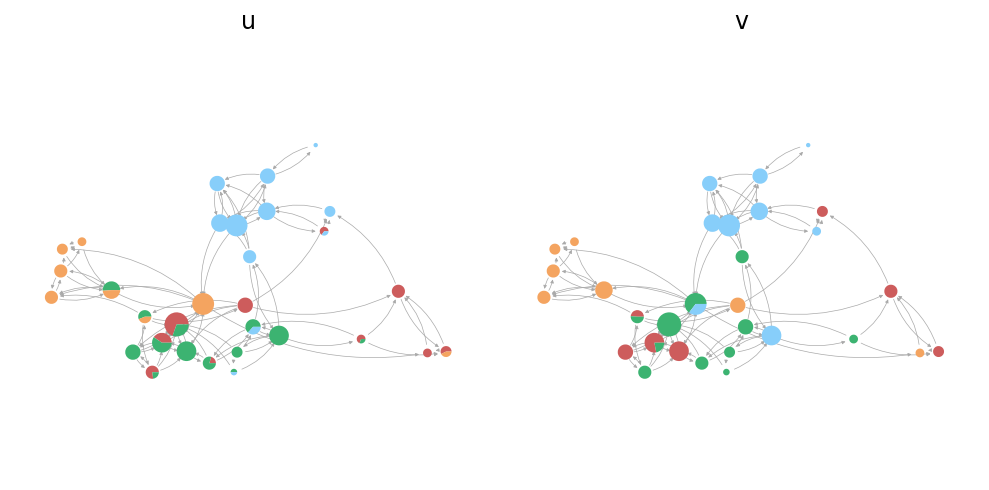

In [12]:
from pgm.output.plot import plot_soft_membership

# Call the plot_soft_membership function from the pgm.output.plot module.
_ = plot_soft_membership(graph,
                         thetas,
                         pos,
                         node_size,
                         colors,
                         edge_color)

### Network reconstruction

Now that we have explored the community structure and soft memberships within our network using `JointCRep`, let's move on to network reconstruction. In this section, we focus on reconstructing the adjacency matrix and analyzing the precision and recall of the joint distribution.

In [13]:
from pgm.output.evaluate import expected_computation
# Convert the sparse adjacency matrix B to a dense representation
Bdense = B.toarray()

# Extract the inferred parameters from the JointCRep model
# U, V, and W are the mixed-membership matrices for the outgoing, incoming, 
# and joint memberships respectively.
# eta is the reciprocity parameter, and maxL is the maximum log-likelihood 
# achieved during the model fitting.
U, V, W, eta, maxL = parameters_jointcrep

# Compute the marginal and conditional expected values of the adjacency matrix.
# These expected values are based on the inferred parameters and provide a 
# measure of the model's fit to the data.
M_marginal, M_conditional = expected_computation(B=Bdense, 
                                                 U=U, 
                                                 V=V, 
                                                 W=W, 
                                                 eta=eta)

### Adjacency matrix

In this step, we transform the sparse adjacency matrix (`B`) into a dense representation (`Bdense`). We then utilize the inferred parameters (`U`, `V`, `W`, `eta`) obtained from `JointCRep` to compute both the marginal and conditional expected values of the adjacency matrix using the `expected_computation` function.

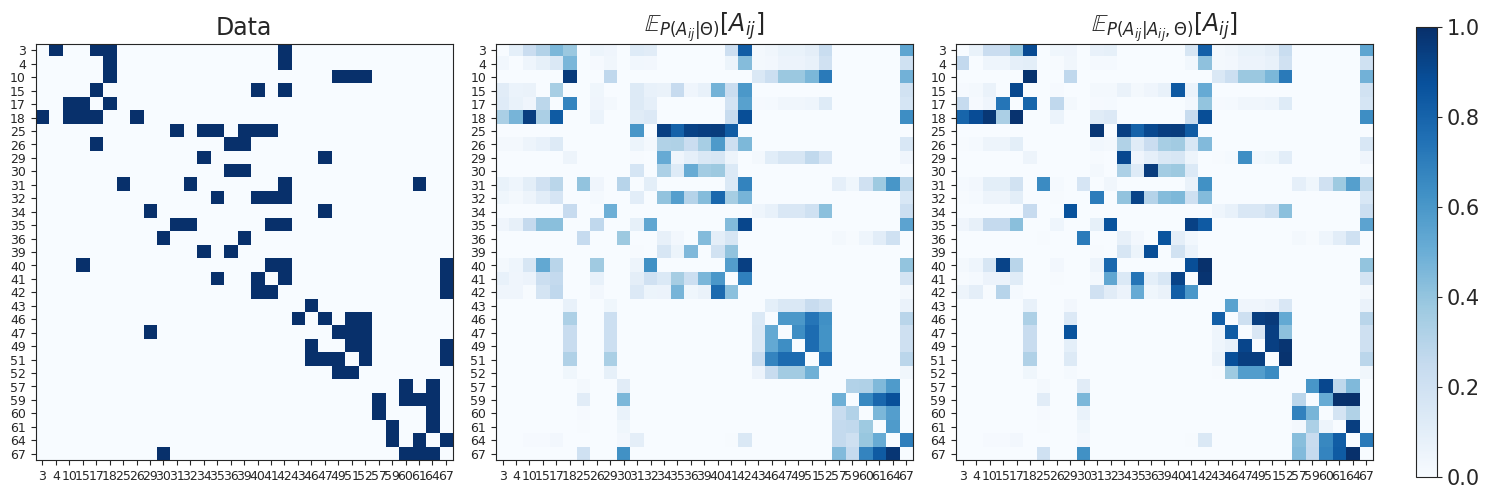

In [12]:
from pgm.output.plot import plot_adjacency

# Call the plot_adjacency function from the pgm.output.plot module.
# This function generates a visualization of the adjacency matrix 
# of the network.
# 'Bdense' is the dense representation of the adjacency matrix.
# 'M_marginal' and 'M_conditional' are the marginal and 
# conditional expected values of the adjacency matrix.
# 'nodes' is a list of nodes in the network.
_ = plot_adjacency(Bdense,
                   M_marginal,
                   M_conditional,
                   nodes)

### NetworkX graph

Next, we visualize the reconstructed adjacency matrix as a Networkx graph. The `plot_graph` function displays the network structure, incorporating information about the marginal and conditional expectations. Node sizes are scaled based on their degrees, providing insights into the nodes' connectivity within the reconstructed network.

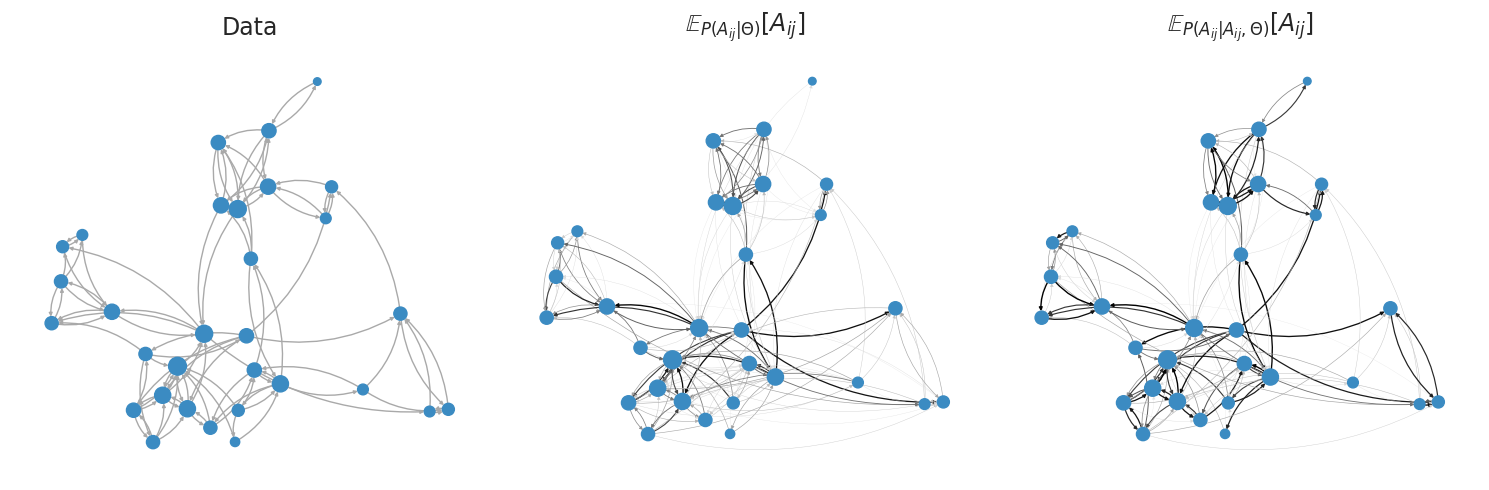

In [13]:
from pgm.output.plot import plot_graph
# Define the size of each node in the graph, proportional to its degree
node_size = [graph.degree[i] * 15 for i in list(graph.nodes())]

# Call the plot_graph function from the pgm.output.plot module
# This function generates a visualization of the network.
# 'graph' is the NetworkX graph object representing the network.
# 'M_marginal' and 'M_conditional' are the marginal and conditional 
# expected values of the adjacency matrix.
_ = plot_graph(graph, 
               M_marginal, 
               M_conditional, 
               pos, 
               node_size, 
               node_color, 
               edge_color)

### Precision and recall of the joint distribution

Moving forward, we evaluate the precision and recall of the joint distribution. By computing the joint probability for every pair of edges and comparing them to the ground truth labels, we gain a comprehensive understanding of how well `JointCRep` captures the structural patterns in the network. The `compute_M_joint` function extracts inferred and true labels, and the resulting confusion matrix is visualized using the `plot_precision_recall` function. This analysis sheds light on the model's performance in distinguishing between different edge configurations.

In [15]:
from pgm.output.evaluate import compute_M_joint

# Compute the joint probability for every pair of edges in the network
# The joint probability is represented as a vector of probabilities 
# p=[p00,p01,p10,p11].
# 'U', 'V', 'W' are the mixed-membership matrices for the outgoing, 
# incoming, and joint memberships respectively.
# 'eta' is the reciprocity parameter.
# The function 'compute_M_joint' from the 'pgm.output.evaluate' 
# module is used to perform this computation.
# The resulting joint probabilities are stored in 'p00', 'p01', 'p10', 'p11'.
p00, p01, p10, p11 = compute_M_joint(U=U, V=V, W=W, eta=eta)

In [16]:
# Define the total number of nodes in the graph
N = len(nodes)

# Generate indices for the upper triangle of a (N, N) matrix
idx_upper = np.triu_indices(N, k=1)

# Define the possible labels for pairs of edges
inf_labels = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Initialize lists to store the true and predicted labels
true_labels, pred_labels = [], []

# Iterate over each pair of nodes in the upper triangle of the adjacency 
# matrix.
for i, j in zip(*idx_upper):
    # Append the true label for the pair of edges to the 'true_labels' list
    # The true label is determined by looking up the pair of edge values in 
    # the 'inf_labels' list.
    true_labels.append(inf_labels.index((int(Bdense[0, i, j]), 
                                         int(Bdense[0, j, i]))))
    
    # Compute the probabilities for each possible label for the pair of edges
    # The probabilities are computed based on the joint probabilities 
    # 'p00', 'p01', 'p10', 'p11'.
    probs = [p00[0, i, j], p01[0, i, j], p10[0, i, j], p11[0, i, j]]
    
    # Normalize the probabilities so that they sum to 1
    probs /= sum(probs)
    
    # Append the predicted label for the pair of edges to the 
    # 'pred_labels' list.
    # The predicted label is the one with the highest 
    # probability.
    pred_labels.append(np.argmax(probs))

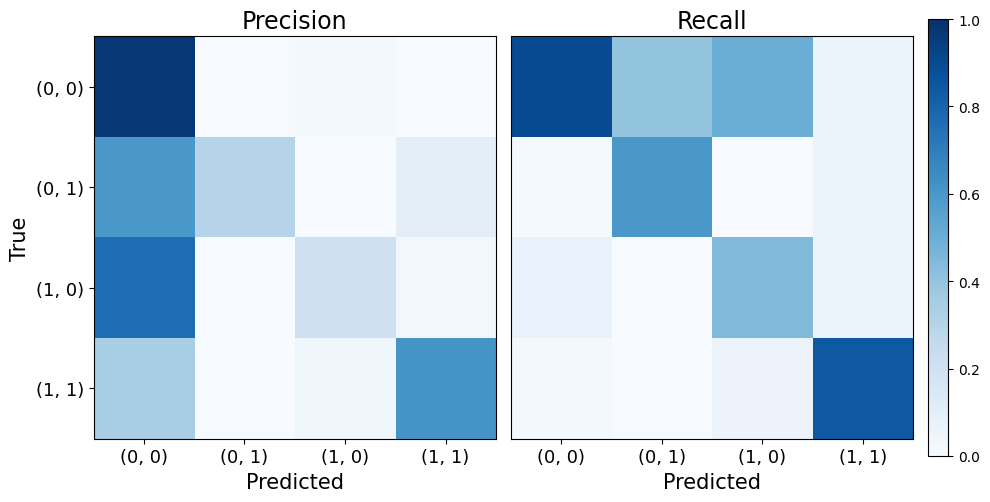

In [17]:
from pgm.output.plot import plot_precision_recall

# Compute the confusion matrix between the true and predicted labels
# The confusion matrix is a table that is often used to describe the 
# performance of a classification model.
# Each row of the matrix represents the instances in a predicted class, 
# while each column represents the instances in an actual class.
# The function 'confusion_matrix' from the sklearn.metrics module 
# is used to compute the confusion matrix.
conf_matrix = sklearn.metrics.confusion_matrix(true_labels, pred_labels)

# Call the plot_precision_recall function from the pgm.output.plot module.
# Precision is the ratio of correctly predicted positive observations to 
# the total predicted positive observations.
# Recall (Sensitivity) - the ratio of correctly predicted positive 
# observations to the all observations in actual class.
# 'conf_matrix' is the confusion matrix computed in the previous step.
_ = plot_precision_recall(conf_matrix)

### Sampled Networks

In this section, we explore the generation of sampled networks based on the inferred parameters from the `JointCRep` model. Utilizing the mean degree of the observed network, we employ the `ReciprocityMMSBM_joints` model to generate five sampled networks. Each sample provides a representation of the network structure, considering reciprocity and community patterns.

To initiate the process, we calculate the mean degree (`k`) of the observed network and set up parameters for generating samples. The `ReciprocityMMSBM_joints` model, influenced by `JointCRep`'s parameterization, is employed to generate diverse network samples.

In [18]:
# Create a list of degrees for each node in the graph
degrees = [graph.degree(n) for n in graph.nodes()]

# Calculate the mean degree of the nodes in the graph
# This gives an average measure of connectivity in the network
k = np.mean(degrees)

In [19]:
from pgm.input.generate_network import ReciprocityMMSBM_joints

# Set the number of communities
K = conf['K']

# Initialize an empty list to store the generated samples
Bsampled = []

# Set the seed for the random number generator to ensure reproducibility
np.random.seed(17)

# Generate a random seed for the ReciprocityMMSBM_joints model
rseed = np.random.randint(18)

# Generate five samples with different random seeds
for i in range(5):
    # Call the ReciprocityMMSBM_joints model from the 
    # pgm.input.generate_network module.
    # This model generates a network sample based on 
    # the inferred parameters from the JointCRep model.
    # 'N' is the total number of nodes in the graph.
    # 'K' is the number of communities.
    # 'avg_degree' is the average degree of the nodes in 
    # the graph.
    # 'show_details' and 'show_plots' are flags to control 
    # the verbosity of the output.
    # 'eta' is the reciprocity parameter
    # 'parameters' is a list containing the mixed-membership 
    # matrices U, V, and W.
    # 'seed' is the random seed for the model.
    # 'output_net' is a flag to control whether the output 
    # should be a NetworkX graph object or an adjacency matrix.
    syn = ReciprocityMMSBM_joints(N=N, 
                                  K=K, 
                                  avg_degree=k, 
                                  show_details=True, 
                                  show_plots=False,
                                  eta=eta, 
                                  parameters=[U, V, W], 
                                  seed=rseed, 
                                  output_net=False)
    
    # Append the adjacency matrix of the generated network 
    # to the 'Bsampled' list.
    Bsampled.append(syn.layer_graphs[0].toarray())

    # Update the random seed for the next iteration.
    rseed += np.random.randint(1, 18)

Number of edges and average degree in each layer:
E[0] = 100 - <k> = 6.452
Sparsity [0] = 0.104
Reciprocity (networkX) = 0.4
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.25

Number of edges and average degree in each layer:
E[0] = 101 - <k> = 6.516
Sparsity [0] = 0.105
Reciprocity (networkX) = 0.535
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.365

Number of edges and average degree in each layer:
E[0] = 100 - <k> = 6.452
Sparsity [0] = 0.104
Reciprocity (networkX) = 0.52
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.351

Number of edges and average degree in each layer:
E[0] = 97 - <k> = 6.258
Sparsity [0] = 0.101
Reciprocity (networkX) = 0.454
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 0.293

Number of edges and average degree in each layer:
E[0] = 90 - <k> = 5.806
Sparsity [0] = 0.094
Recipr

Finally, we visualize the original network's adjacency matrix alongside the five generated samples using the `plot_adjacency_samples function`. This visualization aids in comparing the structural features of the observed network with those of the generated samples. It offers insights into the variability and consistency of the sampled networks produced by the `JointCRep` model.

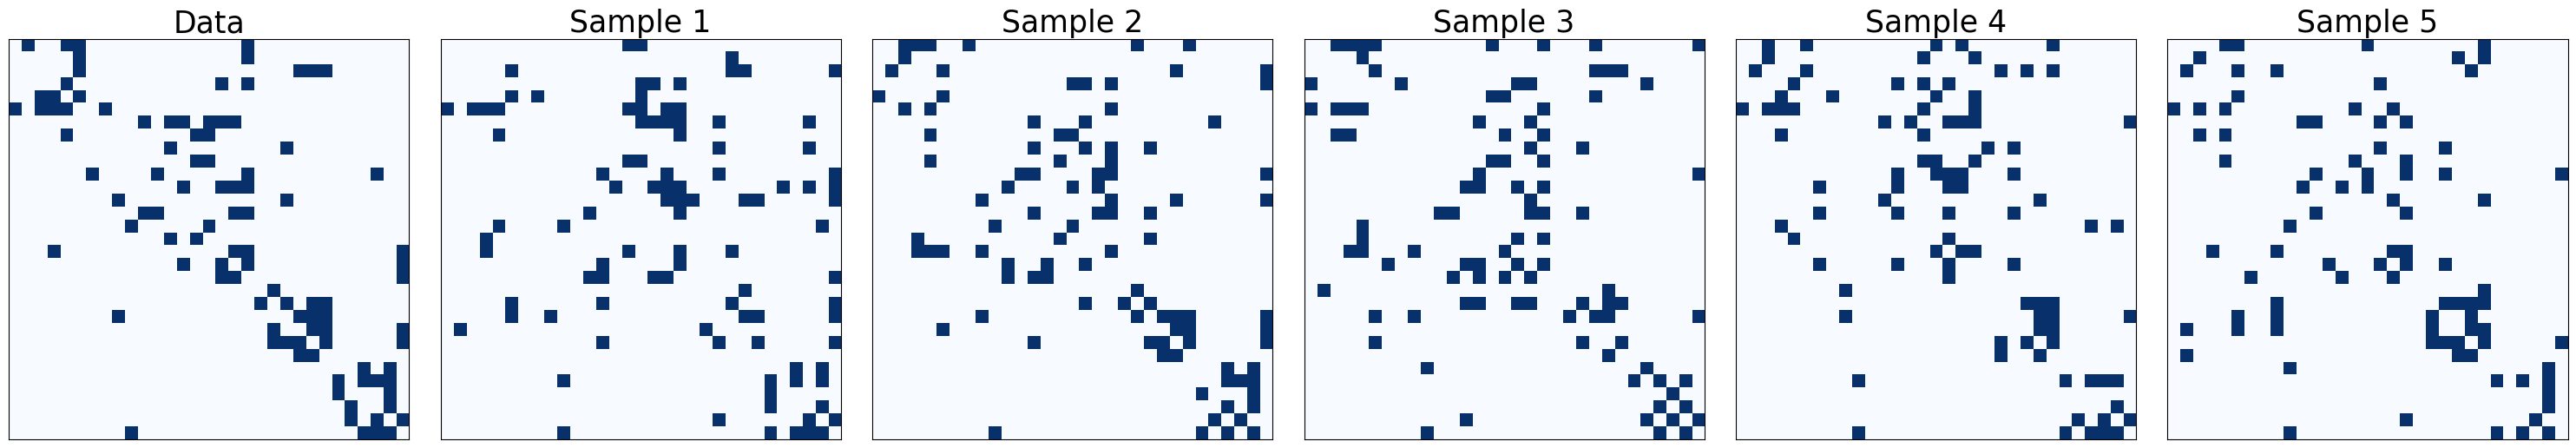

In [20]:
from pgm.output.plot import plot_adjacency_samples

# Call the plot_adjacency_samples function
# 'Bdense' is the adjacency matrix of the original network
# 'Bsampled' is a list of adjacency matrices of the generated 
# samples.
# The function generates a plot comparing the adjacency matrix 
# of the original network with those of the generated samples.
_ = plot_adjacency_samples(Bdense, Bsampled)

This way, we have shown completed a second tutorial on the `pgm` package, focusing on the `JointCRep` algorithm for community detection and capturing reciprocity in networks. This versatile package equips you with powerful tools for network analysis. Explore further and refer to the documentation for ongoing insights.

## References
[1] Hadiseh Safdari, Martina Contisciani, Caterina De Bacco. “A generative model for reciprocity and community detection in networks.” _Phys. Rev. Research_ Vol 3, 023209, 2021.